In [191]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [192]:
# setup
INPUT_PATH = "../input/house-prices-advanced-regression-techniques/train.csv"
HOLDOUT_PATH = "../input/house-prices-advanced-regression-techniques/test.csv"
SUBMISSION_PATH = "../input/house-prices-advanced-regression-techniques/sample_submission.csv"
DATA_DESC_PATH = "../input/house-prices-advanced-regression-techniques/data_description.txt"


In [193]:
input_df = pd.read_csv(INPUT_PATH)
holdout_df = pd.read_csv(HOLDOUT_PATH)
input_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


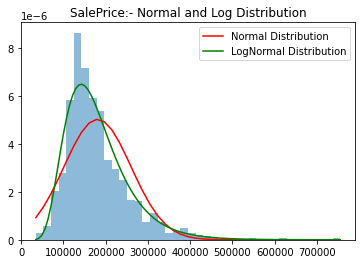

In [194]:
# lets check the distribution of the SalePrice column
_, bins, _ = plt.hist(input_df["SalePrice"], 40, density=1, alpha=0.5)
mu1, sigma1 = scipy.stats.norm.fit(input_df["SalePrice"])
best_fit_line1 = scipy.stats.norm.pdf(bins, mu1, sigma1)
plt.plot(bins, best_fit_line1, color = "red", label = "Normal Distribution")

shape, loc, scale = scipy.stats.lognorm.fit(input_df["SalePrice"])
xmin = input_df["SalePrice"].min()
xmax = input_df["SalePrice"].max()
x = np.linspace(xmin, xmax, 100)
best_fit_line2 = scipy.stats.lognorm.pdf(x, shape, scale=scale)
plt.plot(x, best_fit_line2, color = "green", label = "LogNormal Distribution")
plt.title("SalePrice:- Normal and Log Distribution")
plt.legend()
plt.show()


<AxesSubplot:ylabel='Frequency'>

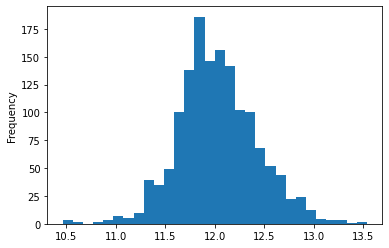

In [195]:
# Lets transform the SalePrice column using the Log function
input_df["SalePrice"] = np.log1p(input_df["SalePrice"])
input_df["SalePrice"].plot.hist(bins = 30)

In [196]:
# get rid of the columns that influence the SalePrice
sale_related_columns = ["MoSold", "YrSold", "SaleType", "SaleCondition"]
input_df = input_df.drop(columns = sale_related_columns)
holdout_df = holdout_df.drop(columns = sale_related_columns)

In [197]:
qualitative_columns = input_df.columns[input_df.dtypes == "object"]
quantitative_columns = input_df.columns[input_df.dtypes != "object"].drop(["Id", "SalePrice"])

In [198]:
input_df.shape, holdout_df.shape

((1460, 77), (1459, 76))

In [199]:
input_df[qualitative_columns].isnull().sum().sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrType         8
Electrical         1
CentralAir         0
HeatingQC          0
Heating            0
KitchenQual        0
PavedDrive         0
Functional         0
MSZoning           0
Street             0
ExterCond          0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
ExterQual          0
Foundation         0
dtype: int64

In [200]:
input_df[quantitative_columns].isnull().sum().sort_values(ascending=False)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
GarageCars         0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
MSSubClass         0
FullBath           0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
GarageArea         0
BsmtHalfBath       0
BsmtFullBath       0
GrLivArea          0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
TotalBsmtSF        0
BsmtUnfSF          0
BsmtFinSF2         0
BsmtFinSF1         0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
LotArea            0
MiscVal            0
dtype: int64

In [201]:
# get rid of the qual columns with lot of nulls
qual_cols_to_remove = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
qualitative_columns = qualitative_columns.drop(qual_cols_to_remove)
input_df = input_df.drop(columns = qual_cols_to_remove)
holdout_df = holdout_df.drop(columns = qual_cols_to_remove)

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

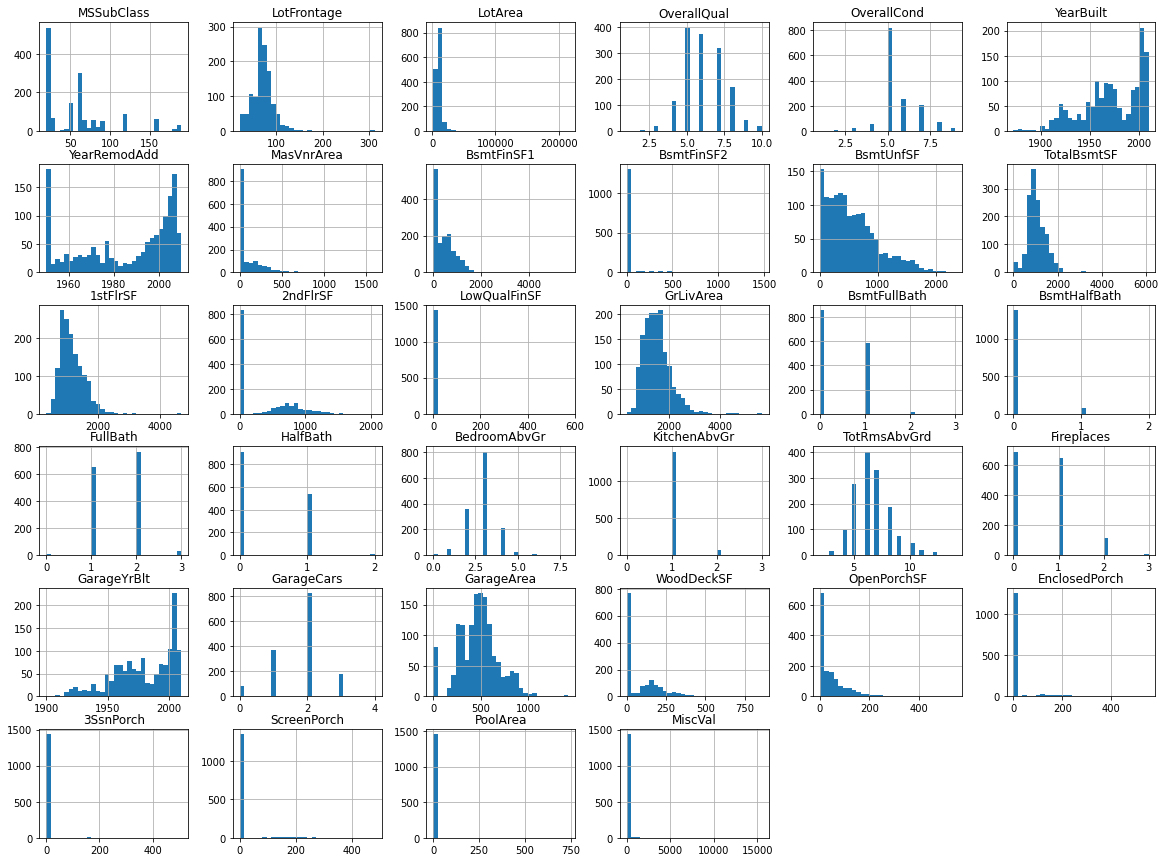

In [202]:
input_df[quantitative_columns].hist(bins=30, figsize=(20, 15))

In [203]:
# Deal with Quantitative features

# Merge all Porch related columns
def merge_porch_features(df):
    df["total_porch_sqft"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    df = df.drop(columns = ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"])
    return df

# Merge Bathroom related features
def merge_bathroom_features(df):
    df["total_baths"] = df["FullBath"] + (0.5 * df["HalfBath"]) + df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])
    df = df.drop(columns = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"])
    return df

# create garage car * area
def create_garage_car_area_feature(df):
    df["garage_car_area"] = df["GarageCars"] * df["GarageArea"]
    df = df.drop(columns = ["GarageCars", "GarageArea", "GarageYrBlt"])
    return df

# deal with sqft features
def sqft_features(df):
    df = df.drop(columns = ["1stFlrSF", "2ndFlrSF", "BsmtUnfSF", "BsmtFinSF2", "BsmtFinSF1", "LowQualFinSF"])
    return df

# year mapper
def year_mapper(year):
    if year >= 1950 and year < 1960:
        return 1
    elif year >= 1960 and year < 1970:
        return 2
    elif year >= 1970 and year < 1980:
        return 3
    elif year >= 1980 and year < 1990:
        return 4
    elif year >= 1990 and year < 2000:
        return 5
    else:
        return 6

# process LotFrontage
def process_lotfrontage(df):
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].mean())
    return df

# process MasVnrArea
def process_masvnrarea(df):
    df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].mean())
    return df

input_df = merge_porch_features(input_df)
input_df = merge_bathroom_features(input_df)
input_df = create_garage_car_area_feature(input_df)
input_df = sqft_features(input_df)
input_df["year_mapped"] = input_df["YearRemodAdd"].apply(year_mapper)
input_df = process_lotfrontage(input_df)
input_df = process_masvnrarea(input_df)

holdout_df = merge_porch_features(holdout_df)
holdout_df = merge_bathroom_features(holdout_df)
holdout_df = create_garage_car_area_feature(holdout_df)
holdout_df = sqft_features(holdout_df)
holdout_df["year_mapped"] = holdout_df["YearRemodAdd"].apply(year_mapper)
holdout_df = process_lotfrontage(holdout_df)
holdout_df = process_masvnrarea(holdout_df)

quant_features_to_add = ["total_porch_sqft", "total_baths", "garage_car_area", "year_mapped"]
quant_features_to_drop = ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt", "1stFlrSF", "2ndFlrSF", "BsmtUnfSF", "BsmtFinSF2", "BsmtFinSF1", "LowQualFinSF", "YearBuilt", "YearRemodAdd"]

quantitative_columns = quantitative_columns.union(quant_features_to_add)
quantitative_columns = quantitative_columns.drop(quant_features_to_drop)

In [204]:
# deal with Qualitative columns

# drop garage related columns since we are already using those in Quantitative feature
def drop_garage_cols(df):
    df = df.drop(columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"])
    return df

# def fill categorical NaN values with mode
def process_null_values(df):
    cols = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "MasVnrType", "Electrical", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", "KitchenQual", "Functional"]
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

qualitative_columns = qualitative_columns.drop(["GarageType", "GarageFinish", "GarageQual", "GarageCond"])

input_df = drop_garage_cols(input_df)
input_df = process_null_values(input_df)

holdout_df = drop_garage_cols(holdout_df)
holdout_df = process_null_values(holdout_df)


In [205]:
qualitative_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'PavedDrive'],
      dtype='object')

In [206]:
input_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,Fireplaces,PavedDrive,WoodDeckSF,PoolArea,MiscVal,SalePrice,total_porch_sqft,total_baths,garage_car_area,year_mapped
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,Y,0,0,0,12.247699,61,3.5,1096,6
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,1,Y,298,0,0,12.109016,0,2.5,920,3
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,1,Y,0,0,0,12.317171,42,3.5,1216,6
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,1,Y,0,0,0,11.849405,307,2.0,1926,3
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,1,Y,192,0,0,12.429220,84,3.5,2508,6


In [207]:
quantitative_columns

Index(['BedroomAbvGr', 'Fireplaces', 'GrLivArea', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'OverallCond',
       'OverallQual', 'PoolArea', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
       'garage_car_area', 'total_baths', 'total_porch_sqft', 'year_mapped'],
      dtype='object')

In [208]:
input_df[quantitative_columns].head(5)

,BedroomAbvGr,Fireplaces,GrLivArea,KitchenAbvGr,LotArea,LotFrontage,MSSubClass,MasVnrArea,MiscVal,OverallCond,OverallQual,PoolArea,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,garage_car_area,total_baths,total_porch_sqft,year_mapped
0,3,0,1710,1,8450,65.0,60,196.0,0,5,7,0,8,856,0,1096,3.5,61,6
1,3,1,1262,1,9600,80.0,20,0.0,0,8,6,0,6,1262,298,920,2.5,0,3
2,3,1,1786,1,11250,68.0,60,162.0,0,5,7,0,6,920,0,1216,3.5,42,6
3,3,1,1717,1,9550,60.0,70,0.0,0,5,7,0,7,756,0,1926,2.0,307,3
4,4,1,2198,1,14260,84.0,60,350.0,0,5,8,0,9,1145,192,2508,3.5,84,6


In [209]:
# perform standard scaler on quantitative columns
std_scaler_cols = ["GrLivArea", "LotArea", "LotFrontage", "MSSubClass", "MasVnrArea", "MiscVal", "PoolArea", "TotalBsmtSF", "WoodDeckSF", "garage_car_area", "total_porch_sqft", "total_baths"]
minmax_cols = ["BedroomAbvGr", "Fireplaces", "KitchenAbvGr", "OverallCond", "OverallQual", "TotRmsAbvGrd", "year_mapped"]

for col in std_scaler_cols:
    scaler = StandardScaler()
    scaler.fit(input_df[[col]])
    input_df[col] = scaler.transform(input_df[[col]])
    holdout_df[col] = scaler.transform(holdout_df[[col]])
    
for col in minmax_cols:
    minmaxer = MinMaxScaler()
    minmaxer.fit(input_df[[col]])
    input_df[col] = minmaxer.transform(input_df[[col]])
    holdout_df[col] = minmaxer.transform(holdout_df[[col]])   

In [210]:
input_df[quantitative_columns].head(5)

,BedroomAbvGr,Fireplaces,GrLivArea,KitchenAbvGr,LotArea,LotFrontage,MSSubClass,MasVnrArea,MiscVal,OverallCond,OverallQual,PoolArea,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,garage_car_area,total_baths,total_porch_sqft,year_mapped
0,0.375,0.000000,0.370333,0.333333,-0.207142,-0.229372,0.073375,0.511418,-0.087688,0.500,0.666667,-0.068692,0.500000,-0.459303,-0.752176,0.168124,1.642256,-0.248063,1.0
1,0.375,0.333333,-0.482512,0.333333,-0.091886,0.451936,-0.872563,-0.574410,-0.087688,0.875,0.555556,-0.068692,0.333333,0.466465,1.626195,-0.079945,0.368581,-0.828163,0.4
2,0.375,0.333333,0.515013,0.333333,0.073480,-0.093110,0.073375,0.323060,-0.087688,0.500,0.666667,-0.068692,0.333333,-0.313369,-0.752176,0.337262,1.642256,-0.428750,1.0
3,0.375,0.333333,0.383659,0.333333,-0.096897,-0.456474,0.309859,-0.574410,-0.087688,0.500,0.666667,-0.068692,0.416667,-0.687324,-0.752176,1.337995,-0.268257,2.091355,0.4
4,0.500,0.333333,1.299326,0.333333,0.375148,0.633618,0.073375,1.364570,-0.087688,0.500,0.777778,-0.068692,0.583333,0.199680,0.780197,2.158314,1.642256,-0.029337,1.0


In [211]:
holdout_df["TotalBsmtSF"] = holdout_df["TotalBsmtSF"].fillna(holdout_df["TotalBsmtSF"].mean())
holdout_df["garage_car_area"] = holdout_df["garage_car_area"].fillna(holdout_df["garage_car_area"].mean())
holdout_df["total_baths"] = holdout_df["total_baths"].fillna(holdout_df["total_baths"].mean())

In [212]:
# convert categorical columns using OHE
categorical_features = []
for col in qualitative_columns:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(input_df[[col]])
    input_enc_df = pd.DataFrame(ohe.transform(input_df[[col]]).toarray())
    holdout_enc_df = pd.DataFrame(ohe.transform(holdout_df[[col]]).toarray())
    input_enc_df.columns = ohe.get_feature_names([col])
    holdout_enc_df.columns = ohe.get_feature_names([col])
    input_df = pd.concat([input_df, input_enc_df], axis = 1)
    input_df = input_df.drop(columns = col)
    holdout_df = pd.concat([holdout_df, holdout_enc_df], axis = 1)
    holdout_df = holdout_df.drop(columns = col)
    categorical_features = categorical_features + ohe.get_feature_names([col]).tolist()

In [213]:
input_df.shape, holdout_df.shape

((1460, 223), (1459, 222))

In [214]:
quantitative_columns

Index(['BedroomAbvGr', 'Fireplaces', 'GrLivArea', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'OverallCond',
       'OverallQual', 'PoolArea', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
       'garage_car_area', 'total_baths', 'total_porch_sqft', 'year_mapped'],
      dtype='object')

In [215]:
# Linear Regression on quantitative features alone
features = quantitative_columns.union(categorical_features)
target = "SalePrice"
lr = RidgeCV(alphas=[0.001, 0.01, 0.1, 0.25, 0.5, 1])
scores = cross_val_score(lr, input_df[features], input_df[target], cv=10)
mean_score = np.mean(scores)
print(mean_score)


0.8716140285672619


In [216]:
features.size, quantitative_columns.size, len(categorical_features)

(219, 19, 200)

In [217]:
def select_features(X, Y, model):
    selector = RFECV(model,cv=5, scoring = "neg_root_mean_squared_error")
    selector.fit(X, Y)
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

In [218]:
lr = RidgeCV(alphas=[0.001, 0.01, 0.1, 0.25, 0.5, 1])
best_features = select_features(input_df[features], input_df[target], lr)

Best Columns 
------------
['BedroomAbvGr', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BsmtCond_Fa', 'BsmtCond_Po', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_TA', 'CentralAir_N', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Po', 'ExterCond_TA', 'ExterQual_Ex', 'ExterQual_Fa', 'Exterior1st_AsbShng', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Ex

In [219]:
lr = RidgeCV(alphas=[0.001, 0.01, 0.1, 0.25, 0.5, 1])
lr.fit(input_df[best_features], input_df[target])
raw_predictions = lr.predict(holdout_df[best_features])
final_predictions = np.floor(np.expm1(raw_predictions))


In [220]:
final_predictions[0:10]

array([112121., 151221., 174823., 193218., 204219., 171684., 182140.,
       162741., 196520., 121041.])

In [ ]:
ids = holdout_df["Id"]
predictions = final_predictions
submission = pd.DataFrame(
    {
        "Id": ids,
        "SalePrice": predictions
    }
)

submission.to_csv("submission.csv", index=False)


In [ ]:
submission.head(5)